# Descriptive analysis of Monant Medical Misinformation Dataset (CSV dump)

## Initialization

Import of necessary libraries

In [1]:
%matplotlib inline

import re
import json
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## Helper functions

### Get data

In [2]:
def get_entity_df(entity, columns_to_skip = []):
    entity_key = entity_to_entity_key(entity)
    df = pd.read_csv('full_data/' + entity_key + '.csv', sep=',', usecols=lambda x: x not in columns_to_skip)
    return df

In [3]:
def entity_to_entity_key(entity):
    entity_key = re.sub('-', '_', entity)
    return entity_key

## Data preprocessing

In [4]:
df = {}
df['articles'] = get_entity_df('articles', ['body', 'raw_body', 'perex', 'other_info', 'url']).set_index('id')
df['fact-checking-articles'] = get_entity_df('fact-checking-articles').set_index('id')
df['claims'] = get_entity_df('claims').set_index('id')
df['discussion-posts'] = get_entity_df('discussion-posts', ['title', 'body', 'body_raw', 'url']).set_index('id')

In [5]:
df['entity-annotations'] = get_entity_df('entity-annotations').set_index('id')

df['relation-annotations'] = get_entity_df('relation-annotations')
df['relation-annotations'].value = df['relation-annotations'].value.fillna('{}')
df['relation-annotations'] = df['relation-annotations'].join(df['relation-annotations']['value'].apply(json.loads).apply(pd.Series), how='left', rsuffix='_annotation_value')
df['relation-annotations'] = df['relation-annotations'].set_index('id')

In [6]:
df['sources'] = get_entity_df('sources')
df_tmp = df['entity-annotations'][df['entity-annotations'].annotation_type_id == 1]
df['sources'] = df['sources'].merge(df_tmp, how='left', left_on='id', right_on='entity_id', suffixes=('_source', '_entity_annotation'))

df['sources'].value = df['sources'].value.fillna('{}')
df['sources'] = df['sources'].join(df['sources']['value'].apply(json.loads).apply(pd.Series), how='left', rsuffix='_reliability_rating')
df['sources'].value_reliability_rating = df['sources'].value_reliability_rating.fillna('unknown')
df['sources'] = df['sources'].set_index('id')

# Descriptive Analysis of Raw Data

In the following descriptive analysis, we focus medical English data, which are contained in the provided dataset.

Dataset contains in total:

In [7]:
for entity in ['articles', 'sources', 'fact-checking-articles', 'claims', 'discussion-posts']:
    print('Number of ' + str(entity) + ': ' + str(len(df[entity])))
    
    if entity in ['sources']:
        print('Average number of articles per source: ' + str(round(len(df['articles']) / len(df[entity]), 2)))

Number of articles: 316832
Number of sources: 215
Average number of articles per source: 1473.64
Number of fact-checking-articles: 3297
Number of claims: 3423
Number of discussion-posts: 710993


### Sources

In [8]:
print('Number of articles\' sources: ' + str(len(df['articles']['source_id'].unique())))
print('Number of medical fact checking articles\' sources: ' + str(len(df['fact-checking-articles']['source_id'].unique())))

Number of articles' sources: 208
Number of medical fact checking articles' sources: 7


In [9]:
for reliability in ['reliable', 'unreliable', 'unknown']:
    print('Number of articles\' ' + str(reliability) + ' sources: ' + str(len(df['sources'][(df['sources'].index.isin(df['articles']['source_id'].unique())) & (df['sources'].value_reliability_rating == reliability)])))

Number of articles' reliable sources: 22
Number of articles' unreliable sources: 48
Number of articles' unknown sources: 138


### Articles

In [10]:
for reliability in ['reliable', 'unknown', 'unreliable']:
    sources = df['sources'][df['sources'].value_reliability_rating == reliability]
    articles = df['articles'][df['articles'].source_id.isin(sources.index.tolist())]
        
    print('Number of articles from ' + str(reliability) + ' sources: ' + str(len(articles)))
    print('Percentage of articles from ' + str(reliability) + ' sources: ' + str(round(len(articles)*100/len(df['articles']), 2)) + ' %')

Number of articles from reliable sources: 123227
Percentage of articles from reliable sources: 38.89 %
Number of articles from unknown sources: 16408
Percentage of articles from unknown sources: 5.18 %
Number of articles from unreliable sources: 177197
Percentage of articles from unreliable sources: 55.93 %


In [11]:
day_start = '-01-01'
day_end = '-12-31'
year_start = 1998
year_end = 2022
request_URL = 'articles'

years = []
n_articles_year = []

for year in range(year_start, year_end + 1, 1):
    date_start = str(year) + day_start
    date_end = str(year) + day_end
    
    years.append(year)
    n_articles_year.append(len(df['articles'][(df['articles']['published_at'] > date_start) & (df['articles']['published_at'] < date_end)]))

Number of English medical articles published in years 1995-(freeze time year):


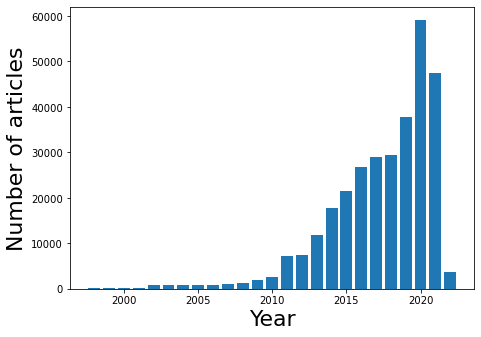

In [12]:
print('Number of English medical articles published in years 1995-(freeze time year):')
plt.rcParams['figure.figsize'] = 7, 5
plt.rcParams['figure.autolayout'] = True
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['pdf.use14corefonts'] = True

font = {'size': 17} 
f = plt.figure()
plt.xlabel('Year', fontsize=22)
plt.ylabel('Number of articles', fontsize=22)
matplotlib.rc('font', **font)
plt.bar(years, n_articles_year)

f.savefig("image_export/articles_timeline.pdf", bbox_inches='tight')

### Fact-checking articles & Claims

In [13]:
for index, row in df['fact-checking-articles'].groupby('source_id').size().reset_index(name='count').iterrows():
    source_name = df['sources'].loc[row['source_id']]['name']
    source_n_articles = row['count']
    print('Number of fact checking articles from source ' + str(source_name) + ': ' + str(source_n_articles))

Number of fact checking articles from source factcheck.org: 30
Number of fact checking articles from source politifact.com: 1
Number of fact checking articles from source metafact.io: 1093
Number of fact checking articles from source healthfeedback.org: 435
Number of fact checking articles from source snopes.com: 768
Number of fact checking articles from source fullfact.org: 967
Number of fact checking articles from source sciencefeedback.co: 3


In [14]:
ratings = []
n_claims_ratings = []
ratings_names_dict = {
    'null': 'Unknown',
    'unknown': 'Unknown',
    'false': 'False',
    'mostly-false': 'Mostly\nfalse',
    'mixture': 'Mixture',
    'mostly-true': 'Mostly\ntrue',
    'true': 'True'
}

print('Number of claims: ' + str(len(df['claims'])))
print('\n')

claims_medical_n_rating_unknown = len(df['claims'])
for rating in ['false', 'mostly-false', 'mixture', 'mostly-true', 'true']:
    claims_medical_n_rating = len(df['claims'][df['claims'].rating == rating])
    print('Number of ' + str(rating) + 'claims: ' + str(claims_medical_n_rating))
    print(f"Percentage of {str(rating)} claims: {round((claims_medical_n_rating / len(df['claims']) * 100), 2)} %\n")
    claims_medical_n_rating_unknown = claims_medical_n_rating_unknown - claims_medical_n_rating
    
    ratings.append(ratings_names_dict[rating])
    n_claims_ratings.append(claims_medical_n_rating)
    
    
rating = 'unknown'
print('Number of ' + str(rating) + ' claims: ' + str(claims_medical_n_rating_unknown))
print(f"Percentage of {str(rating)} claims: {round((claims_medical_n_rating_unknown / len(df['claims']) * 100), 2)} %\n")
ratings.append(rating)
n_claims_ratings.append(claims_medical_n_rating_unknown)

Number of claims: 3423


Number of falseclaims: 983
Percentage of false claims: 28.72 %

Number of mostly-falseclaims: 60
Percentage of mostly-false claims: 1.75 %

Number of mixtureclaims: 100
Percentage of mixture claims: 2.92 %

Number of mostly-trueclaims: 39
Percentage of mostly-true claims: 1.14 %

Number of trueclaims: 259
Percentage of true claims: 7.57 %

Number of unknown claims: 1982
Percentage of unknown claims: 57.9 %



Number of medical claims in our dataset per claim rating:


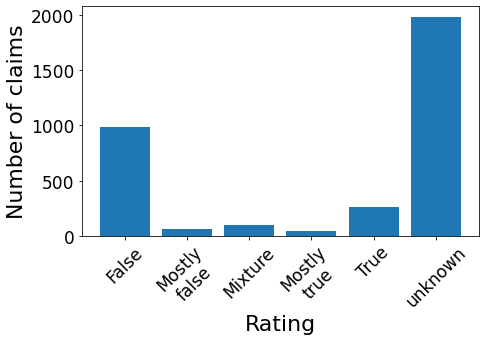

In [15]:
print('Number of medical claims in our dataset per claim rating:')
plt.rcParams['figure.figsize'] = 7, 5
plt.rcParams['figure.autolayout'] = True
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['pdf.use14corefonts'] = True

font = {'size': 15} 
f = plt.figure()
plt.xlabel('Rating', fontsize=22)
plt.ylabel('Number of claims', fontsize=22)
matplotlib.rc('font', **font)
plt.xticks(rotation=45)
plt.bar(ratings, n_claims_ratings)

f.savefig("image_export/claims_veracity.pdf", bbox_inches='tight')

# Descriptive Analysis of Manual Annotations

In [16]:
df_presence_annotations = df['relation-annotations'][(df['relation-annotations']['annotation_type_id'] == 2) & (df['relation-annotations']['annotation_category'] == 'label')]

In [17]:
total_count = len(df_presence_annotations[(df_presence_annotations['created_at'] < '2022-01-01') & ((df_presence_annotations['value_annotation_value'] == 'present') | (df_presence_annotations['value_annotation_value'] == 'suggestive') | (df_presence_annotations['value_annotation_value'] == 'not-present'))])

count = len(df_presence_annotations[(df_presence_annotations['created_at'] < '2022-01-01') & ((df_presence_annotations['value_annotation_value'] == 'present') | (df_presence_annotations['value_annotation_value'] == 'suggestive'))])
print('Number of presence labels with value present/suggestive for Sample 1: ' + str(count) + ' (' + str(round(count*100/total_count, 2)) + ' %)')
count = len(df_presence_annotations[(df_presence_annotations['created_at'] < '2022-01-01') & (df_presence_annotations['value_annotation_value'] == 'not-present')])
print('Number of presence labels with value not present for Sample 1: ' + str(count) + ' (' + str(round(count*100/total_count, 2)) + ' %)')
print('Number of presence labels in total for Sample 1: ' + str(total_count))


total_count = len(df_presence_annotations[(df_presence_annotations['created_at'] > '2022-01-01') & ((df_presence_annotations['value_annotation_value'] == 'present') | (df_presence_annotations['value_annotation_value'] == 'suggestive') | (df_presence_annotations['value_annotation_value'] == 'not-present'))])

count = len(df_presence_annotations[(df_presence_annotations['created_at'] > '2022-01-01') & ((df_presence_annotations['value_annotation_value'] == 'present') | (df_presence_annotations['value_annotation_value'] == 'suggestive'))])
print('Number of presence labels with value present/suggestive for Sample 2: ' + str(count) + ' (' + str(round(count*100/total_count, 2)) + ' %)')
count = len(df_presence_annotations[(df_presence_annotations['created_at'] > '2022-01-01') & (df_presence_annotations['value_annotation_value'] == 'not-present')])
print('Number of presence labels with value not present for Sample 2: ' + str(count) + ' (' + str(round(count*100/total_count, 2)) + ' %)')
print('Number of presence labels in total for Sample 2: ' + str(total_count))

total_count = len(df_presence_annotations[((df_presence_annotations['value_annotation_value'] == 'present') | (df_presence_annotations['value_annotation_value'] == 'suggestive') | (df_presence_annotations['value_annotation_value'] == 'not-present'))])

count = len(df_presence_annotations[((df_presence_annotations['value_annotation_value'] == 'present') | (df_presence_annotations['value_annotation_value'] == 'suggestive'))])
print('Number of presence labels with value present/suggestive for both samples: ' + str(count) + ' (' + str(round(count*100/total_count, 2)) + ' %)')
count = len(df_presence_annotations[(df_presence_annotations['value_annotation_value'] == 'not-present')])
print('Number of presence labels with value not present for both samples: ' + str(count) + ' (' + str(round(count*100/total_count, 2)) + ' %)')
print('Number of presence labels in total for both samples: ' + str(total_count))

Number of presence labels with value present/suggestive for Sample 1: 222 (50.57 %)
Number of presence labels with value not present for Sample 1: 217 (49.43 %)
Number of presence labels in total for Sample 1: 439
Number of presence labels with value present/suggestive for Sample 2: 101 (75.37 %)
Number of presence labels with value not present for Sample 2: 33 (24.63 %)
Number of presence labels in total for Sample 2: 134
Number of presence labels with value present/suggestive for both samples: 323 (56.37 %)
Number of presence labels with value not present for both samples: 250 (43.63 %)
Number of presence labels in total for both samples: 573


In [61]:
disagreement_count = 0

for index,presence_annotation in df_presence_annotations.iterrows():
    annotation_values = set()
    for annotation in presence_annotation.annotations:
        annotation_values.add(annotation['value'])
        
    if ('present' in annotation_values or 'suggestive' in annotation_values) and ('not-present' in annotation_values):
        disagreement_count = disagreement_count + 1
        
total_count = len(df_presence_annotations)
print('Number of presence labels in which annotators\' disagreement occured: ' + str(disagreement_count) + ' (' + str(round(disagreement_count*100/total_count, 2)) + ' %)')


Number of presence labels in which annotators' disagreement occured: 63 (8.57 %)


In [19]:
total_count = len(df_stance_annotations[(df_stance_annotations['created_at'] < '2022-01-01') & ((df_stance_annotations['value_annotation_value'] == 'supporting') | (df_stance_annotations['value_annotation_value'] == 'contradicting') | (df_stance_annotations['value_annotation_value'] == 'neutral'))])

count = len(df_stance_annotations[(df_stance_annotations['created_at'] < '2022-01-01') & (df_stance_annotations['value_annotation_value'] == 'supporting')])
print('Number of stance labels with value promoting for Sample 1: ' + str(count) + ' (' + str(round(count*100/total_count, 2)) + ' %)')
count = len(df_stance_annotations[(df_stance_annotations['created_at'] < '2022-01-01') & (df_stance_annotations['value_annotation_value'] == 'contradicting')])
print('Number of stance labels with value contradicting for Sample 1: ' + str(count) + ' (' + str(round(count*100/total_count, 2)) + ' %)')
count = len(df_stance_annotations[(df_stance_annotations['created_at'] < '2022-01-01') & (df_stance_annotations['value_annotation_value'] == 'neutral')])
print('Number of stance labels with value neutral for Sample 1: ' + str(count) + ' (' + str(round(count*100/total_count, 2)) + ' %)')
print('Number of stance labels in total for Sample 1: ' + str(total_count))


total_count = len(df_stance_annotations[(df_stance_annotations['created_at'] > '2022-01-01') & ((df_stance_annotations['value_annotation_value'] == 'supporting') | (df_stance_annotations['value_annotation_value'] == 'contradicting') | (df_stance_annotations['value_annotation_value'] == 'neutral'))])

count = len(df_stance_annotations[(df_stance_annotations['created_at'] > '2022-01-01') & (df_stance_annotations['value_annotation_value'] == 'supporting')])
print('Number of stance labels with value promoting for Sample 2: ' + str(count) + ' (' + str(round(count*100/total_count, 2)) + ' %)')
count = len(df_stance_annotations[(df_stance_annotations['created_at'] > '2022-01-01') & (df_stance_annotations['value_annotation_value'] == 'contradicting')])
print('Number of stance labels with value contradicting for Sample 2: ' + str(count) + ' (' + str(round(count*100/total_count, 2)) + ' %)')
count = len(df_stance_annotations[(df_stance_annotations['created_at'] > '2022-01-01') & (df_stance_annotations['value_annotation_value'] == 'neutral')])
print('Number of stance labels with value neutral for Sample 2: ' + str(count) + ' (' + str(round(count*100/total_count, 2)) + ' %)')
print('Number of stance labels in total for Sample 2: ' + str(total_count))

total_count = len(df_stance_annotations[((df_stance_annotations['value_annotation_value'] == 'supporting') | (df_stance_annotations['value_annotation_value'] == 'contradicting') | (df_stance_annotations['value_annotation_value'] == 'neutral'))])

count = len(df_stance_annotations[(df_stance_annotations['value_annotation_value'] == 'supporting')])
print('Number of stance labels with value promoting for both samples: ' + str(count) + ' (' + str(round(count*100/total_count, 2)) + ' %)')
count = len(df_stance_annotations[(df_stance_annotations['value_annotation_value'] == 'contradicting')])
print('Number of stance labels with value contradicting for both samples: ' + str(count) + ' (' + str(round(count*100/total_count, 2)) + ' %)')
count = len(df_stance_annotations[(df_stance_annotations['value_annotation_value'] == 'neutral')])
print('Number of stance labels with value neutral for both samples: ' + str(count) + ' (' + str(round(count*100/total_count, 2)) + ' %)')
print('Number of stance labels in total for both samples: ' + str(total_count))

Number of stance labels with value promoting for Sample 1: 129 (61.43 %)
Number of stance labels with value contradicting for Sample 1: 62 (29.52 %)
Number of stance labels with value neutral for Sample 1: 19 (9.05 %)
Number of stance labels in total for Sample 1: 210
Number of stance labels with value promoting for Sample 2: 74 (74.75 %)
Number of stance labels with value contradicting for Sample 2: 24 (24.24 %)
Number of stance labels with value neutral for Sample 2: 1 (1.01 %)
Number of stance labels in total for Sample 2: 99
Number of stance labels with value promoting for both samples: 203 (65.7 %)
Number of stance labels with value contradicting for both samples: 86 (27.83 %)
Number of stance labels with value neutral for both samples: 20 (6.47 %)
Number of stance labels in total for both samples: 309


In [60]:
disagreement_count = 0

for index,stance_annotation in df_stance_annotations.iterrows():
    annotation_values = set()
    for annotation in stance_annotation.annotations:
        annotation_values.add(annotation['value'])
        
    if 'supporting' in annotation_values and 'contradicting' in annotation_values or 'supporting' in annotation_values and 'neutral' in annotation_values or 'contradicting' in annotation_values and 'neutral' in annotation_values:
        disagreement_count = disagreement_count + 1
        
total_count = len(df_presence_annotations)
print('Number of stance labels in which annotators\' disagreement occured: ' + str(disagreement_count) + ' (' + str(round(disagreement_count*100/total_count, 2)) + ' %)')

Number of stance labels in which annotators' disagreement occured: 51 (6.94 %)


# Descriptive Analysis of Predicted Annotations

Besides raw data and manual labels, the introduced dataset also contains the predicted annotations (for claims presence, article stance and article-claim pair veracities).

In [20]:
df['entity-annotations_veracity'] = df['entity-annotations'][(df['entity-annotations']['annotation_type_id'] == 6) & (df['entity-annotations']['annotation_category'] == 'prediction')].copy()

In [21]:
df['entity-annotations_veracity'].value = df['entity-annotations_veracity'].value.fillna('{}')
df['entity-annotations_veracity'] = df['entity-annotations_veracity'].join(df['entity-annotations_veracity']['value'].apply(json.loads).apply(pd.Series), rsuffix='_veracity_rating')
df['entity-annotations_veracity'] = df['entity-annotations_veracity'][df['entity-annotations_veracity']['claims'].map(lambda d: len(d)) > 0]

In [22]:
sources = df['sources'][df['sources'].value_reliability_rating == 'reliable']
articles = df['articles'][df['articles'].source_id.isin(sources.index.tolist())]
articles_reliable_ids = list(articles.index.tolist())

sources = df['sources'][df['sources'].value_reliability_rating == 'unreliable']
articles = df['articles'][df['articles'].source_id.isin(sources.index.tolist())]
articles_unreliable_ids = list(articles.index.tolist())

In [23]:
ac_pairs_present_yes = 0
ac_pairs_present_no = 0

claims_present_id = set()
claims_present_not_id = set()

veracity_set = {'false', 'mixture', 'mostly-false', 'mostly-true', 'true', 'unknown'}
claims_pveracity_n = dict()
for veracity in veracity_set:
    claims_pveracity_n[veracity] = 0
    
stance_set = {'contradicting', 'neutral', 'supporting'}
claims_stance_n = dict()
for stance in stance_set:
    claims_stance_n[stance] = 0
    
veracity_consistency_set = {'true', 'false', 'inconsistent'}
veracity_consistency_n = dict()
for veracity in veracity_consistency_set:
    veracity_consistency_n[veracity] = 0
    
veracity_binary_set = {' true', ' false', ''}
reliability_set = {'unreliable', 'reliable', 'unknown'}
veracity_reliability_n = dict()

for reliability in reliability_set:
    for veracity in veracity_binary_set:
        veracity_reliability_n[reliability + veracity] = 0


for index, row in df['entity-annotations_veracity'].iterrows():
    
    if int(row['entity_id']) in articles_reliable_ids:
        source_reliability = 'reliable' 
    elif int(row['entity_id']) in articles_unreliable_ids:
        source_reliability = 'unreliable'
    else:
        source_reliability = 'unknown'
    
    article_veracity_init = True
    veracity_consistent = True
    
    for claim in row['claims']:
        
        if claim['presence'] == 'yes':
            ac_pairs_present_yes = ac_pairs_present_yes + 1
            
            claims_present_id.add(claim['claim_id'])
            
            if claim['stance'] in claims_stance_n:
                claims_stance_n[claim['stance']] = claims_stance_n[claim['stance']] + 1
            else:
                claims_stance_n['neutral'] = claims_stance_n['neutral'] + 1
            
            claims_pveracity_n[claim['partial_veracity']] = claims_pveracity_n[claim['partial_veracity']] + 1
            veracity_reliability_n[source_reliability] = veracity_reliability_n[source_reliability] + 1
            
            if (claim['partial_veracity'] in {'false', 'mostly-false', 'mostly-true', 'true'}):
                if claim['partial_veracity'] in {'mostly-true', 'true'}:
                    claim_veracity = 'true'
                    veracity_reliability_n[source_reliability + ' ' + claim_veracity] = veracity_reliability_n[source_reliability +' '+ claim_veracity] + 1
                if claim['partial_veracity'] in {'false', 'mostly-false'}:
                    claim_veracity = 'false'
                    veracity_reliability_n[source_reliability + ' ' + claim_veracity] = veracity_reliability_n[source_reliability +' '+ claim_veracity] + 1
                    
                if article_veracity_init:
                    article_veracity = claim_veracity
                    article_veracity_init = False
                    
                if article_veracity != claim_veracity:
                    veracity_consistent = False

    if article_veracity_init == False:
            if veracity_consistent:
                veracity_consistency_n[article_veracity] = veracity_consistency_n[article_veracity] + 1
            else:
                veracity_consistency_n['inconsistent'] = veracity_consistency_n['inconsistent'] + 1

ac_pairs_present_all = len(df['relation-annotations'][(df['relation-annotations']['annotation_type_id'] == 2) & (df['relation-annotations']['annotation_category'] == 'prediction')])
ac_pairs_present_no = ac_pairs_present_all - ac_pairs_present_yes

print('Number of not present article-claim mappings: ' + str(ac_pairs_present_no))
print('Number of present article-claim mappings: ' + str(ac_pairs_present_yes))

print('\n')

print('Number of mapped articles: ' + str(len(df['entity-annotations_veracity'])))
print(f"Percentage of mapped articles : {round((len(df['entity-annotations_veracity']) / len(df['articles']) * 100), 2)} %\n")

print('\n')

print('Number of mapped claims: ' + str(len(claims_present_id)))
print(f"Percentage of mapped claims: {round((len(claims_present_id) / len(df['claims']) * 100), 2)} %\n")

print('\n')

print('Number of present mapped claims with stance: ' + str(ac_pairs_present_yes))
for stance,number in claims_stance_n.items():
    print('Number of present mapped claims with ' + str(stance) + ' stance: ' + str(number))
    print(f"Percentage of present mapped claims with {str(stance)} stance: {round((number / ac_pairs_present_yes * 100), 2)} %\n")
print('\n')

print('Number of present mapped claims with partial veracity: ' + str(ac_pairs_present_yes))                                                                              
for veracity,number in claims_pveracity_n.items():
    print('Number of present mapped claims with ' + str(veracity) + ' partial veracity: ' + str(number))
    print(f"Percentage of present mapped claims with {str(veracity)} partial veracity: {round((number / ac_pairs_present_yes * 100), 2)} %\n")
    
print('\n')
                                                                            
for veracity,number in veracity_consistency_n.items():
    print('Number of mapped articles witch veracity consistancy status ' + str(veracity) + ': ' + str(number))
    print(f"Percentage of mapped articles witch veracity consistancy status {str(veracity)}: {round((number / len(df['entity-annotations_veracity']) * 100), 2)} %\n")
    
print('\n')
       
for rating,number in veracity_reliability_n.items():
    if rating in ['unreliable', 'reliable', 'unknown']:
        print('Number of present claim article pairs - ' + str(rating) + ' sources: ' + str(number))
        print(f"Percentage of present claim article pairs - {str(rating)} sources: {round((number / ac_pairs_present_yes * 100), 2)} %\n")
    else:
        reliability = rating.split()[0]
        veracity = rating.split()[1]
        print('Number of present claim article pairs - ' + str(veracity) + ' veracity from ' + str(reliability) + ' source: ' + str(number))
        print(f"Percentage of present claim article pairs from {str(reliability)} sources - {str(veracity)} veracity from {str(reliability)} source: {round((number / veracity_reliability_n[reliability] * 100), 2)} %\n")

Number of not present article-claim mappings: 365528
Number of present article-claim mappings: 50953


Number of mapped articles: 34850
Percentage of mapped articles : 11.0 %



Number of mapped claims: 1193
Percentage of mapped claims: 34.85 %



Number of present mapped claims with stance: 50953
Number of present mapped claims with supporting stance: 40168
Percentage of present mapped claims with supporting stance: 78.83 %

Number of present mapped claims with neutral stance: 2065
Percentage of present mapped claims with neutral stance: 4.05 %

Number of present mapped claims with contradicting stance: 8720
Percentage of present mapped claims with contradicting stance: 17.11 %



Number of present mapped claims with partial veracity: 50953
Number of present mapped claims with unknown partial veracity: 31828
Percentage of present mapped claims with unknown partial veracity: 62.47 %

Number of present mapped claims with true partial veracity: 8814
Percentage of present mapped claims wi

In [24]:
claims_source_names = dict()
claims_sources_names_set = set()

for claim_id in claims_present_id:
    fcas = df['relation-annotations'][(df['relation-annotations'].target_entity_type == 'claims') & (df['relation-annotations'].target_entity_id == claim_id) & (df['relation-annotations'].source_entity_type == 'fact_checking_articles')]
    
    if len(fcas) > 0:
        fc = df['fact-checking-articles'].loc[fcas.iloc[0].source_entity_id]
        source = df['sources'].loc[fc['source_id']]
        source_name = source['name']

        claims_source_names[claim_id] = source_name
        claims_sources_names_set.add(source_name)
    else:
        claims_source_names[claim_id] = 'unknown'
        claims_sources_names_set.add('unknown')

In [25]:
claims_source_names_n = dict()
for source_name in claims_sources_names_set:
    claims_source_names_n[source_name] = 0
claims_source_names_n['Ghenai 2018'] = 0

for index, row in df['entity-annotations_veracity'].iterrows():
    for claim in row['claims']:
        if claim['claim_id'] in range(5300, 5431, 1):
            source_name = 'Ghenai 2018'
        elif claim['claim_id'] in [5690]:
            # Fix: This particular fact-checking article (and corresponding claim) was probably originally marked with a tag as medical and the tag was removed later
            source_name = 'metafact.io'
        else:
            source_name = claims_source_names[claim['claim_id']]
        claims_source_names_n[source_name] = claims_source_names_n[source_name] + 1

In [26]:
for source_name,number in claims_source_names_n.items():
    print('Number of present mapped article-claim pairs - claims from source '+ str(source_name) + ': ' + str(number))
    print(f"Percentage of present mapped article-claim pairs - claims from source {str(source_name)}: {round((number / ac_pairs_present_yes * 100), 2)} %\n")

Number of present mapped article-claim pairs - claims from source snopes.com: 793
Percentage of present mapped article-claim pairs - claims from source snopes.com: 1.56 %

Number of present mapped article-claim pairs - claims from source unknown: 0
Percentage of present mapped article-claim pairs - claims from source unknown: 0.0 %

Number of present mapped article-claim pairs - claims from source sciencefeedback.co: 6
Percentage of present mapped article-claim pairs - claims from source sciencefeedback.co: 0.01 %

Number of present mapped article-claim pairs - claims from source healthfeedback.org: 4878
Percentage of present mapped article-claim pairs - claims from source healthfeedback.org: 9.57 %

Number of present mapped article-claim pairs - claims from source fullfact.org: 9418
Percentage of present mapped article-claim pairs - claims from source fullfact.org: 18.48 %

Number of present mapped article-claim pairs - claims from source factcheck.org: 2
Percentage of present mapped 